In [16]:
import copy
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from scipy.io import loadmat
from sklearn.decomposition import PCA

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [32]:
def load_churchland_data(path, times=(-50,150)):
    """
    Load data from Churchland 2012
    Data available here: 
    https://churchland.zuckermaninstitute.columbia.edu/content/code
    
    Returns a 3D data array, T x N x C. T is the number of time bins,
    and N is the number of neurons (218), and C is the number of conditions.

    Note: Loading a .mat struct in Python is quite messy beause the formatting is messed up,
    which is why we need to do some funky indexing here.
    """
    struct = loadmat(path)
    conditions = struct["Data"][0]

    # For this dataset, times are the same for all conditions,
    # but they are formatted strangely -- each element of the times
    # vector is in a separate list.
    datas = None
    times = [t[0] for t in conditions[0][1]]
    
    for i, cond in enumerate(conditions):
        spikes = cond[0]
        if datas is None:
            datas = spikes
        else:
            datas = np.dstack((datas, spikes))
    
    datas = np.moveaxis(datas, 2, 0)
    return datas, times
    
def preprocess_churchland_data(datas,
                               times,
                               tstart=-50,
                               tend=150,
                               soft_normalize=5,
                               subtract_cc_mean=True,
                               pca=True,
                               num_pcs=6):
    
    num_conditions, num_time_bins, num_units = datas.shape

    # Adapted from original jPCA matlab code. Normalized firing rate is 
    # computed by dividing by the range of the unit across all conditions and times
    # plus the soft_normalize constant: Y_{ijc} = (max(Y_{i::}) - min(Y_{i::}) + C)
    # where Y_{ijc} is the ith neuron, at the jth time bin, for the cth condition.
    # C is the constant provided by soft_normalize. Set C negative to skip the 
    # soft-normalizing step.

    if soft_normalize > 0:
        fr_range = np.max(datas, axis=(0,1)) - np.min(datas, axis=(0,1))
        datas /= (fr_range + soft_normalize)
        
    if subtract_cc_mean:
        cc_mean = np.mean(datas, axis=0)
        datas -= cc_mean
        
    if pca:
        # Reshape to perform PCA on all trials at once.
        datas = datas.reshape(num_time_bins * num_conditions, num_units)
        pca = PCA(num_pcs)
        datas = pca.fit_transform(datas)
        datas = datas.reshape(num_conditions, num_time_bins, num_pcs)

        
    # For consistency with the original jPCA matlab code,
    # we normalize and compute PCA using the full dataset.
    # In practice this should not make much difference.
    # We return the data as a 3D array to make it easy to match
    # trials and neural data.
    idx_start = times.index(tstart)
    idx_end = times.index(tend) + 1 # Add one so idx is inclusive
    return copy.deepcopy(datas[idx_start:idx_end, :, :])
    
        
N = 6
D = 6

DATA_PATH = "/Users/Bantin/Documents/Linderman-Shenoy/jPCA_ForDistribution/exampleData.mat"
datas, times = load_churchland_data(DATA_PATH)
datas = preprocess_churchland_data(datas, times, pca=True, num_pcs=N)

In [39]:
# Create a rotational LDS for jPCA

data_list = [Y for Y in datas]
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian")
# %lprun -f ssm.emissions.GaussianOrthogonalEmissions.m_step lds.fit(data_list, num_iters=1)
elbos, posterior = lds.fit(data_list, num_iters=20)

Initializing with an ARHMM using 25 steps of EM.


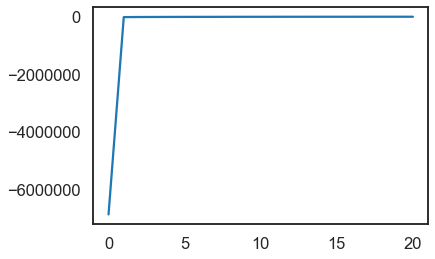

In [40]:
plt.plot(elbos)

In [41]:
transition_mat = lds.dynamics.A
projected_datas = ssm.preprocessing.jPCA_project(posterior.mean_continuous_states,
                                                 transition_mat,
                                                 num_components=4)


/Users/bantin/Documents/Linderman-Shenoy/ssm/ssm/preprocessing.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  jpca_basis[:, k] = v1


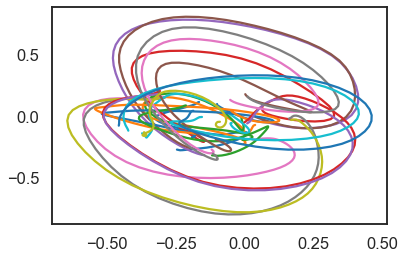

In [43]:
for d in projected_datas:
    plt.plot(d[:,0], d[:,1])